# **INTRODUCTION**
In this notebook I am going to try to create a model to predict the stock market.  I am going to try to do this with a RandomForestRegressor. We will be using the yfinance library to pull market data. We will hae to do some data cleaning, and a lot of feature engineering to find viable predictors that can will result in a meaningful prediction on future market movement. Join me as I create a model from start to finish

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
stock = yf.Ticker("MARA")
stock = stock.history(period="max").tz_localize(None)

In [ ]:
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-04,53.040001,119.599998,53.040001,119.599998,6,0.0,0.0
2012-05-07,119.599998,119.599998,119.599998,119.599998,0,0.0,0.0
2012-05-08,53.040001,104.000000,53.040001,104.000000,6,0.0,0.0
2012-05-09,104.000000,104.000000,104.000000,104.000000,0,0.0,0.0
2012-05-10,104.000000,104.000000,104.000000,104.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-12,21.500000,22.070000,18.760000,18.980000,137407900,0.0,0.0
2024-01-16,18.650000,19.040001,17.180000,17.780001,106408800,0.0,0.0
2024-01-17,17.500000,17.980000,16.620001,17.260000,76361100,0.0,0.0


<Axes: xlabel='Date'>

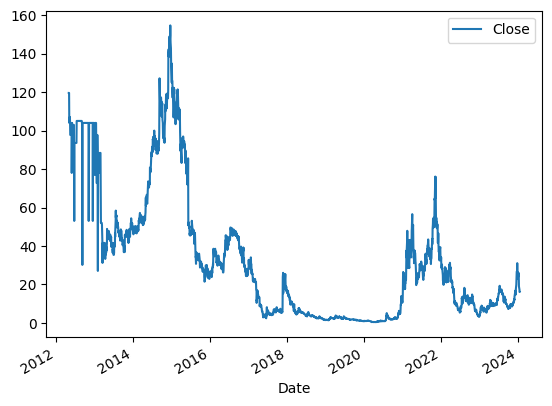

In [ ]:
stock.plot.line(y="Close", use_index=True)

In [ ]:
del stock["Dividends"]
del stock["Stock Splits"]

In [ ]:
# Data Engineering for a target column, this will be what we use to train our model
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2012-05-04,53.040001,119.599998,53.040001,119.599998,6,119.599998,0
2012-05-07,119.599998,119.599998,119.599998,119.599998,0,104.000000,0
2012-05-08,53.040001,104.000000,53.040001,104.000000,6,104.000000,0
2012-05-09,104.000000,104.000000,104.000000,104.000000,0,104.000000,0
2012-05-10,104.000000,104.000000,104.000000,104.000000,0,105.040001,1
...,...,...,...,...,...,...,...
2024-01-12,21.500000,22.070000,18.760000,18.980000,137407900,17.780001,0
2024-01-16,18.650000,19.040001,17.180000,17.780001,106408800,17.260000,0
2024-01-17,17.500000,17.980000,16.620001,17.260000,76361100,16.070000,0


In [ ]:
# Making a Random Forest Classifier, this is the model that we will use to make our model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1) # n_estimators is num trees in the forset, min_sample_split is proteccts against overfitting, but may sacrifice accuracy)
train = stock.iloc[:-100]
test = stock.iloc[-100:-1]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test['Target'], preds)

0.39285714285714285

**The reason we use Precision**

Precision, when used in data science/statistics refers to: True Positives / False Positives + True Positives.

In other words, precision is a way of measuring how confident you model is on your 'positive' prediction. In the context of this project, precision describe how confident the model is that the market will go up when it predicts the market will go up (a 'positive' prediction is a prediction that the stock will go up).

For example: A precision score of 80p means that when the model predicted the price will go up, 80p of the time it went up.

Precision is a good measure for this project becuase for the stock market we want to be sure that when we invest our money into a stock, it will go up. We do not care if the stock goes up when we didn't think it would go up, becuase even though that may of been missed oppurtuity, we didn't lose money and there will be more oppurtunities.
**Note:** I am ingoring shorting

<Axes: xlabel='Date'>

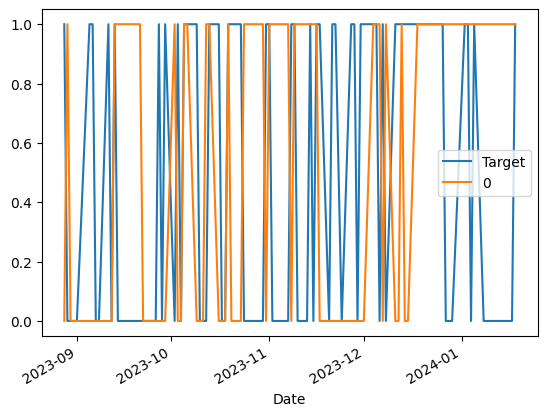

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

Since the stock market moves in trends, and these trends change over time, it is not a great idea to train a moedel over a long period of time. To combat this change over time we are going to introduce backtesting.  With backtesting are to train and test the data over different periods of time.

For example we can train on the first 2500 days, and test on the next 250, then we can train on the first 2750 dadys and test on the next 250, then train on first 3000 and test on the next 250, and so on. This way we hope to catch trends that change with time

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

def backtest(data, model, predictors, start=300, step=30):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i]
    test = data.iloc[i:(i+step)]
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(stock, model, predictors)
predictions['Predictions'].value_counts()

0.0    2484
1.0     162
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.42592592592592593

To interpret if this precision score is good or not, we can look at the percentage of days that the stock actually went up.

To do this we just have to divide the number of days the stock actually went up by the number of days in the data set.

Once we have this number we can compare this number to our model and see if our model did any beter. If it did do better, that means our model has more  predictive power then just blindly waking up every day, buying the stock, and selling at the end of the day.

In [ ]:
predictions['Target'].value_counts() / predictions.shape[0] # Check accuracy

0    0.579743
1    0.420257
Name: Target, dtype: float64

So it looks like right now the stock performs about the same as blindly buying it every day, but this is okay as we have not really done any feature egineering or anything else to improve the model, lets if we can by doing so.


---



Now that we have run our model with backtesting using some standard predictors, lets try to add more meaninful predictors and see if we can improve our precision.

First we are going to try to add the rolling averages, and overall trend (up or down) to our predictors.

In [ ]:
# creating rolling avgs
horizons = [2, 5, 60, 250, 1000] # these are rolling averages (2 day, 5 day, 60 day, etc)
new_predictors = []

for horizon in horizons:
  rolling_averages = stock.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]
new_predictors += predictors

In [ ]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'Close',
 'Volume',
 'Open',
 'High',
 'Low']

In [ ]:
stock2 = stock.dropna().copy()
stock2

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2016-04-27,28.799999,29.760000,27.360001,28.959999,2813,29.120001,1,0.994505,1.0,0.982628,2.0,0.877576,22.0,0.731514,93.0,0.417971,341.0
2016-04-28,29.120001,30.240000,28.799999,29.120001,950,28.639999,0,1.002755,1.0,1.001100,2.0,0.882781,23.0,0.740223,94.0,0.420830,342.0
2016-04-29,28.799999,29.280001,27.360001,28.639999,4213,27.680000,0,0.991690,1.0,0.993341,2.0,0.870058,22.0,0.732922,93.0,0.414345,342.0
2016-05-02,28.000000,29.280001,27.680000,27.680000,9606,28.480000,1,0.982955,0.0,0.963252,2.0,0.844108,21.0,0.712990,93.0,0.400899,342.0
2016-05-03,27.200001,28.480000,27.200001,28.480000,1719,27.680000,0,1.014245,1.0,0.996641,2.0,0.872977,21.0,0.738516,93.0,0.412937,343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,27.290001,29.180000,20.750000,22.400000,213408200,18.980000,0,0.932750,0.0,0.904247,1.0,1.485970,34.0,1.961080,125.0,1.385129,471.0
2024-01-12,21.500000,22.070000,18.760000,18.980000,137407900,17.780001,0,0.917351,0.0,0.799360,1.0,1.244604,33.0,1.655115,124.0,1.172342,471.0
2024-01-16,18.650000,19.040001,17.180000,17.780001,106408800,17.260000,0,0.967356,0.0,0.804379,0.0,1.153260,33.0,1.545399,123.0,1.097079,471.0


In [ ]:
#creating a new model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
predictions = backtest(stock2, model, new_predictors)

In [ ]:
print(predictions["Predictions"].value_counts())
print(precision_score(predictions["Target"], predictions["Predictions"]))

0.0    1606
1.0      39
Name: Predictions, dtype: int64
0.358974358974359


In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

0    0.573252
1    0.426748
Name: Target, dtype: float64

so adding the rolling averages did not make it any better, instead it made it worse. lets see if we can disregard this and do more feature engineering.


---



As a trader myself, one thing I have noted is that MARA - A digital asset technology company, which engages in mining cryptocurrencies, moves similarly with bitcoin. So for this reason I am going to try to add some information about bitcoin and see if we are able to increase our precision.

In [ ]:
bitcoin_data = yf.download("BTC-USD", start=stock2.index.min(), end=stock2.index.max())

[*********************100%%**********************]  1 of 1 completed


In [ ]:
bitcoin_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-27,466.261993,467.079010,444.134003,444.687012,444.687012,93564896
2016-04-28,445.037994,449.550995,436.649994,449.010986,449.010986,74064704
2016-04-29,449.407990,455.384003,446.016998,455.096985,455.096985,49258500
2016-04-30,455.178009,455.587006,447.696991,448.317993,448.317993,69322600
2016-05-01,448.484009,452.479004,447.927002,451.875000,451.875000,40660100
...,...,...,...,...,...,...
2024-01-13,42799.445312,43234.660156,42464.144531,42842.382812,42842.382812,20601860469
2024-01-14,42842.261719,43065.597656,41724.613281,41796.269531,41796.269531,17521429522
2024-01-15,41715.066406,43319.722656,41705.417969,42511.968750,42511.968750,22320220558


Lets plot the data to visualize its correlation in movement

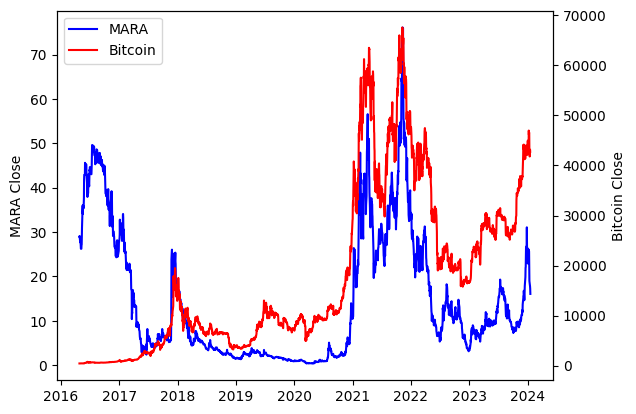

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(stock2["Close"], label="MARA", c="blue")
ax1.set_ylabel("MARA Close")

ax2 = ax1.twinx()
ax2.plot(bitcoin_data["Close"], label="Bitcoin",c="red")
ax2.set_ylabel("Bitcoin Close")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


As the plot indicates, the price movement of both BITCOIN and MARA seem to be similar

In [ ]:
bitcoin_data['Bitcoin_Close'] = bitcoin_data['Close']
bitcoin_data['Bitcoin_Volume'] = bitcoin_data['Volume']

In [ ]:
# merge the data so we have the bicoin close and volume columns
merged_data = pd.merge(stock, bitcoin_data[['Bitcoin_Close', 'Bitcoin_Volume']], left_index=True, right_index=True, how='left')

In [ ]:
merged_data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,Bitcoin_Close,Bitcoin_Volume
Date,,,,,,,,,,,,,,,,,,,
2012-05-04,53.040001,119.599998,53.040001,119.599998,6,119.599998,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-07,119.599998,119.599998,119.599998,119.599998,0,104.000000,0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-08,53.040001,104.000000,53.040001,104.000000,6,104.000000,0,0.930233,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-09,104.000000,104.000000,104.000000,104.000000,0,104.000000,0,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-10,104.000000,104.000000,104.000000,104.000000,0,105.040001,1,1.000000,0.0,0.943396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,21.500000,22.070000,18.760000,18.980000,137407900,17.780001,0,0.917351,0.0,0.799360,1.0,1.244604,33.0,1.655115,124.0,1.172342,471.0,42853.167969,4.333270e+10
2024-01-16,18.650000,19.040001,17.180000,17.780001,106408800,17.260000,0,0.967356,0.0,0.804379,0.0,1.153260,33.0,1.545399,123.0,1.097079,471.0,43154.945312,2.406287e+10
2024-01-17,17.500000,17.980000,16.620001,17.260000,76361100,16.070000,0,0.985160,0.0,0.845664,0.0,1.108091,33.0,1.494823,123.0,1.063923,470.0,42742.652344,2.085123e+10


In [ ]:
merged_data = merged_data.dropna()

In [ ]:
new_predictors = ["Close", "Volume", "Open", "High", "Low", "Bitcoin_Close", "Bitcoin_Volume"]

In [ ]:
predictions = backtest(merged_data, model, new_predictors)

Time to run our model again using backtesting

In [ ]:
print(predictions["Predictions"].value_counts())
print(precision_score(predictions["Target"], predictions["Predictions"]))

0.0    1566
1.0      78
Name: Predictions, dtype: int64
0.47435897435897434


In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

0    0.573601
1    0.426399
Name: Target, dtype: float64

Close: 0.12819313894528347
Volume: 0.18501142799785075
Open: 0.12728846080584186
High: 0.11510233958470532
Low: 0.11851220741076288
Bitcoin_Close: 0.1681777665111325
Bitcoin_Volume: 0.15771465874442328


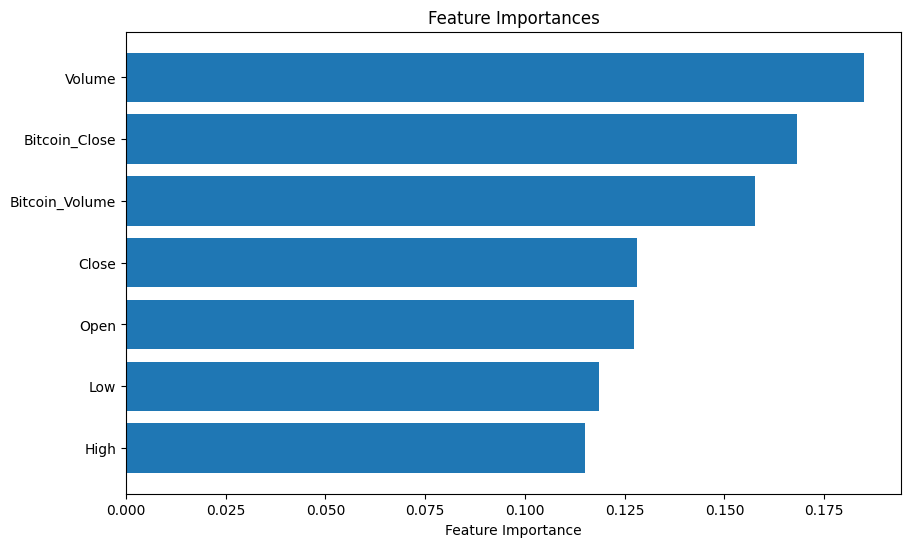

In [ ]:
feature_importances = model.feature_importances_

for feature, importance in zip(new_predictors, feature_importances):
    print(f"{feature}: {importance}")

import matplotlib.pyplot as plt

sorted_indices = np.argsort(feature_importances)
sorted_features = [new_predictors[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

It looks like I was right, implementing Bitcoins close price and volume booster our models precision up to **47%**. This is 5% better then blindly buying and is also the first time we have seen some actual predicting power from our model. Furthermore, by the feature importance chart we can see that bitcoin was the second and third most impactful features out of all features. This is great, lets keep going and see if we can get better precision.

I am going to do some Natural Language Proccesing and attempt to try to implement sentiment analysis into my model. By this I mean trying to look at news headlines/articles and determine if the general PR for a stock is positive or negative and include this in our model.

PR for a stock is essential to it's movement, company mergers, earnings, lawsuits, etc. are all things that may significantly impact a stocks price. Being able to capture this news sentiment may add a vital edge in increasing overall market trend and ultimatley improving precision.  

In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

To do this I will be scraping the html off of finviz.com, a great website to view news articles that people have posted about the stock.  By using the BeautifulSoup library we will retreive the html and then locate each article title and give it a sentiment score using the vader lexicon SentimentIntensityAnalyzer from the nltk library.

In [ ]:
# importing the finviz url
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['MARA']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    # Getting the html
    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table') # all of the articles exist in a html table with id - 'new-tables', so we can grab that
    news_tables[ticker] = news_table

In [ ]:
news_tables

In [ ]:
import re
parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'): # iterate through the table rows
      if row.a: # identify if there is text
        title = row.a.text # assign title
        date_data = row.td.text.split(' ')

        # match the regex for date and time
        date = None
        time = None

        date_pattern = re.compile(r'[a-zA-Z]{3}-\d{2}-\d{2}')
        time_pattern = re.compile(r'\d{2}:\d{2}[APMapm]{2}')

        for item in date_data:
            if date_pattern.match(item):
                date = item.strip()

            elif time_pattern.match(item):
                time = item.strip()

        # append a list with ticker, date, time, and title for every row (article)
        parsed_data.append([ticker, date, time, title])


Now that we have the parsed data we can create a pandas data frame so we can manipulate this data using pandas.

In [ ]:
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

In [ ]:
df = df.dropna()
df

,ticker,date,time,title
0,MARA,Jan-16-24,08:00AM,Marathon Digital Holdings Announces the Closin...
1,MARA,Jan-13-24,07:45AM,Where Will Marathon Digital Stock Be in 10 Years?
2,MARA,Jan-12-24,03:55PM,"Why Marathon Digital, Riot Platforms, and Micr..."
6,MARA,Jan-11-24,09:23PM,Marathon Digital Stock (NASDAQ:MARA): Dont Be ...
11,MARA,Jan-10-24,09:48AM,"Stocks to Watch Wednesday: Boeing, Coinbase, H..."
...,...,...,...,...
95,MARA,Aug-29-23,04:39PM,Cryptocurrencies surge after Grayscales legal ...
96,MARA,Aug-28-23,08:32PM,3 Digital Asset Stocks That Are Better Bets Th...
97,MARA,Aug-18-23,12:51PM,"Here's Where to Invest $1,000 Right Now"
98,MARA,Aug-17-23,04:22PM,Bitcoin sinks below $28K as crypto-tied stocks...


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['sentiment'] = df['title'].apply(f)
df['date'] = pd.to_datetime(df.date).dt.date

In [ ]:
df

,ticker,date,time,title,sentiment
0,MARA,2024-01-16,08:00AM,Marathon Digital Holdings Announces the Closin...,0.0000
1,MARA,2024-01-13,07:45AM,Where Will Marathon Digital Stock Be in 10 Years?,0.0000
2,MARA,2024-01-12,03:55PM,"Why Marathon Digital, Riot Platforms, and Micr...",-0.5574
6,MARA,2024-01-11,09:23PM,Marathon Digital Stock (NASDAQ:MARA): Dont Be ...,0.2057
11,MARA,2024-01-10,09:48AM,"Stocks to Watch Wednesday: Boeing, Coinbase, H...",0.0000
...,...,...,...,...,...
95,MARA,2023-08-29,04:39PM,Cryptocurrencies surge after Grayscales legal ...,0.6486
96,MARA,2023-08-28,08:32PM,3 Digital Asset Stocks That Are Better Bets Th...,0.6597
97,MARA,2023-08-18,12:51PM,"Here's Where to Invest $1,000 Right Now",0.0000
98,MARA,2023-08-17,04:22PM,Bitcoin sinks below $28K as crypto-tied stocks...,0.0000


In [ ]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean()
mean_df = mean_df.xs('sentiment', axis="columns")
mean_df.plot(kind='bar')
plt.show()

Unfortunatley this sentiment data cannot be used in our model. I tried implementing it by creating a new col in the merged_data with the sentiment of the article, and this data was placed in the merged_data df corresponding to the date. But as yu can see there are only 61 rows of sentiment, where there is close to 3000 rows in the merged_data set, and this was part of the reason the sentiment couldn't provide predictive power.

Furthermore, the vader sentiment analysis is not perfect, it often can give us wrong sentiment, which can throw off our models accuracy.


---



Now I am just going to try some more feature engineering, I will make new columns that can possibly add some value to the models predictictive power, starting with volatility.

In [ ]:
merged_data2 = merged_data.copy()

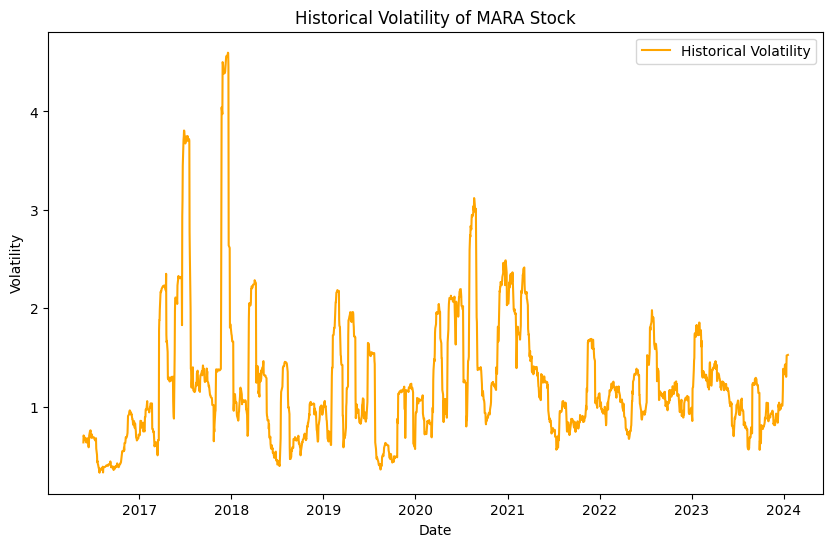

In [ ]:
merged_data2['Log_Ret'] = np.log(merged_data2['Close'] / merged_data2['Close'].shift(1))
merged_data2['Volatility'] = merged_data2['Log_Ret'].rolling(window=20).std() * np.sqrt(252)

# Drop NaN values resulting from the rolling window
merged_data2 = merged_data2.dropna()

# Plot Historical Volatility
plt.figure(figsize=(10, 6))
plt.plot(merged_data2['Volatility'], label='Historical Volatility', color='orange')
plt.title('Historical Volatility of MARA Stock')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
new_predictors = ["Close", "Open", "High", "Low","Volume", "Bitcoin_Close", "Bitcoin_Volume", "Volatility"]

In [ ]:
predictions = backtest(merged_data2, model, new_predictors)

In [ ]:
print(predictions["Predictions"].value_counts())
print(precision_score(predictions["Target"], predictions["Predictions"]))

0.0    1511
1.0     113
Name: Predictions, dtype: int64
0.39823008849557523


In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

0    0.571429
1    0.428571
Name: Target, dtype: float64

Close: 0.11023502885061445
Open: 0.10747277634753528
High: 0.10403615537124997
Low: 0.10325951491552096
Volume: 0.15847068303660472
Bitcoin_Close: 0.1404061680743694
Bitcoin_Volume: 0.13779177797695139
Volatility: 0.13832789542715385


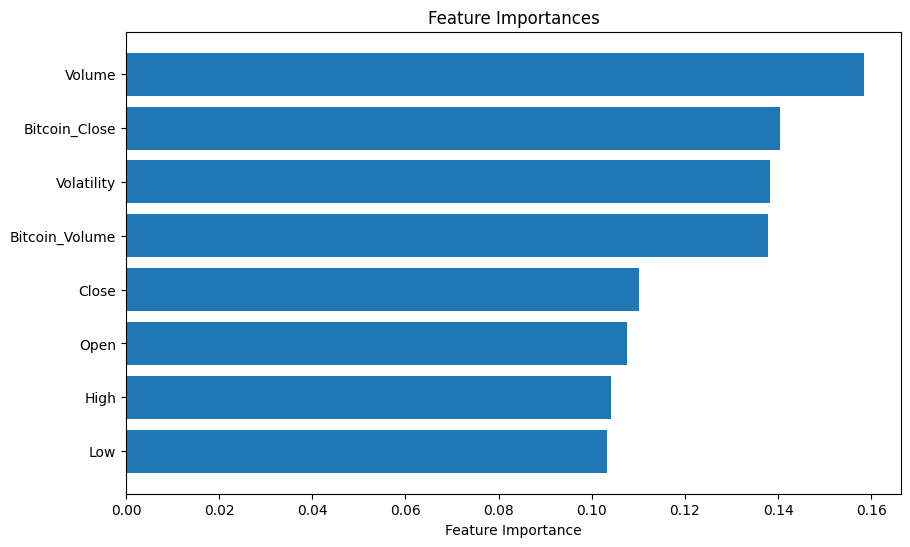

In [ ]:
feature_importances = model.feature_importances_

for feature, importance in zip(new_predictors, feature_importances):
    print(f"{feature}: {importance}")

import matplotlib.pyplot as plt

sorted_indices = np.argsort(feature_importances)
sorted_features = [new_predictors[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

Adding the volatility highlights an interesting and important point to take away from feature engineering. We can see that the model precision went down even though the graph shows that volatility was actually one of the better features. Why?

The answer lies in the way this feature importance ranking is created. Random Forest calculates feature importance based on how much each feature contributes to reducing impurity or variance across all trees (highest information gain).

 The way Random Forests operate (high level): Random subsets of the data are created and decision tres are created for each one. These decision trees predict/classify results based on inputs and then decision trees that did 'bad' are voted out while decision trees that did 'good' stay.

 The way decision trees operate (high level): The features that were passed into the model are ranked based on the inforamtion gain they provide to the tree. Information gain uses a metric called entropy to determine which feature should be used to split the data at each level.  The more the information gain a feature provides, the better it can split the data up so the decision tree can narrow down the classification further.

While feature importance (its avg information gain) can be a valuable tool for understanding the contribution of different features in a model, it does not always guarantee better accuracy.

* **Correlation between Features**: If features are highly correlated, the importance of one feature might overshadow another, leading to redundancy in the model. In such cases, removing one of the correlated features may not necessarily improve accuracy, as the remaining feature still carries similar information.

* **Nonlinear Relationships**: Feature importance is only derived from information gain, which may not capture complex nonlinear relationships in the data. Certain features might be crucial in combination with others, and their individual importance may not fully represent their collective impact.

* **Overfitting to Noisy Features**: Random Forests are robust to overfitting, but they can still capture noise in the data. If noisy features are given high importance, it might lead to overfitting and reduced generalization to new data, impacting accuracy.



---



# Wrapping it Up
So, we've been on a journey to create a stock market predictor for MARA using historical data and machine learning magic. We played around with the yfinance library to get our hands on MARA's historical stock prices and threw a RandomForestClassifier into the mix to predict future stock movements.

### What We Discovered
1. Model Playtime: We trained a RandomForestClassifier using features like closing price, volume, and some technical stuff. To check how good it was doing, we used precision scores, which is just a fancy way of saying, "How often did our model nail it?"

2. Backtesting: We didn't want our model stuck in a time warp, so we did some backtesting. Basically, we trained and tested it over different time periods to make sure it could handle the ever-changing market trends.

3. Feature Fun: We got creative with feature engineering, adding in rolling averages, trends, and  considered the influence of Bitcoin prices and news sentiment. Even though not all of these features improved our model they gave us some insight on what works and doesn't work.

### How We Could Keep Improving
But hey, our model isn't perfect. Here are some ways that can we can do to continue improving it:

1. Get Fancy with Features: Try out more advanced indicators, doing a better job with sentiment analysis, or maybe bring in some unique factors that might really catch the stock trends really well.  

2. Fine-Tune: The RandomForest model has some options that can be tweaked (hyperparameters). Play around with them to see if we can make it even smarter. This is kinda like tuning a radio station to get the clearest signal.

3. LSTMs: LSTMs are like time-travelers for data. They might see patterns our current model misses.  Most relativley successful stock predictor models work on LSTMs.  Doing this would mean that we would have to redo the whole model, becuase RF and LSTMs are quite different. This option would more a "lets restart the project" than "lets improve our project".

4. Highlight Star Features: Figure out which features are the real MVPs and try to focus on improving these.

### Some concluding thoughts
Predicting the stock market with machine learning is historically challenging due to the inherent complexities and uncertainties associated with financial markets. Here are some key reasons:

1. Non-Linearity: Financial markets are dynamic and non-linear. Traditional machine learning models do well with more linearity, trying to capture  intricate, non-linear relationships and patterns in stock price movements is much more complex task.

2. Randomness and Noise: Financial markets are influenced by countless unpredictable factors, including economic events, geopolitical developments, and investor sentiments. The presence of random noise in the data makes it challenging to discern genuine trends from temporary fluctuations.

3. Market Psychology: Investor behavior is influenced by emotions, market psychology, and collective sentiment. The are all factors that introduce an element of unpredictability that is hard to capture in a machine learning model.

4. Model Overfitting: Financial data may have a relatively small number of samples compared to the number of potential features, leading to the risk of overfitting. Overfit models may perform well on training data but fail to generalize effectively to new data.

While machine learning models can provide valuable insights and aid decision-making in finance, the inherent uncertainties and dynamic nature of financial markets pose significant challenges. Successful prediction requires an advanced understanding of market dynamics, continuous model refinement, and consideration of external factors beyond the scope of historical data.